In [1]:
import torch
import math

from tqdm.notebook import tqdm

from torch import nn

import itertools
from functools import partial

import matplotlib.pyplot as plt

import os
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

In [239]:
def solve_sde_RK(b_drift=None, sigma=None, X0=None, dt=1.0, N=100, t0=0.0,
                theta=None, noise=False, forwards=True):
    """
            Euler Mayurama method
    Syntax:
    ----------
    solve_sde(b_drift=None, sigma=None, X0=None, dt=None, N=100, t0=0, DW=None)
    Parameters:
    ----------
        b_drift  : Time dependan drift, the X state (with last dimension as time)
                defines the differential equation.
        sigma  : a  constant volatility
        X0    : Initial conditions of the SDE. Mandatory for SDEs
                with variables > 1 (default: gaussian np.random)
        dt    : The timestep of the solution
                (default: 1)
        N     : The number of timesteps (defines the length of the timeseries)
                (default: 100)
        t0    : The initial time of the solution
                (default: 0)

    """
    N = int(N)+1   # This change is not compatible with 1) below
    if b_drift is None or sigma is None:
        raise ValueError("Error: SDE not defined.")

    n, d, *_ = X0.shape

    T = torch.tensor(dt * N)

    DWs  = torch.empty((n, N-1, d)).normal_(mean=0, std=1) * math.sqrt(dt)


    Y, ti = torch.zeros((n, N, d + 1)).double(), torch.arange(N).double() * dt + t0
    t0rep =  (
        t0 * torch.ones((X0.shape[0], 1)).double() if forwards
        else (T-t0) * torch.ones((X0.shape[0], 1)).double()
    )

    Y = torch.cat((X0, t0rep), axis=1 )[:, None, :]

    T = dt * N
    #print(ti.shape)
    #print(ti)
    #print(N)
    for n in range(N-1):
        t =ti[n+1]    # 1)
        b, DW_n = b_drift(Y[:,n, :]),  DWs[:,n,:]
        newY = (
            Y[:,n, :-1] + b * dt + sigma * DW_n
        )

        trep = (
            t.repeat(newY.shape[0]).reshape(-1,1) if forwards
            else T - t.repeat(newY.shape[0]).reshape(-1,1)
        )
        #print(trep)
        tocat = torch.cat((newY, trep), dim=1)[:, None, :]

        Y = torch.cat((Y,tocat) , dim=1)
    if torch.isnan(Y).any() or torch.isinf(Y).any(): import pdb; pdb.set_trace()

    return ti, Y

In [240]:
def plot_trajectories_2( Xts, t, remove_time=True, fig_axs=None, color='b', show=True, direction="Forward"):
    """
    Helper function that plots multple trajctories
    """
     
    fn = 14
    if fig_axs is None:
        fig, axs = plt.subplots(1,1,  sharey=False, figsize=(15,10))
        axs.set_ylabel("$x(t)$", fontsize=fn)
    else:
        fig, axs = fig_axs

    n, _, _, = Xts.shape
    
    if remove_time:
        Xts = Xts[...,:-1]

    for i in range(n):
        label = "$\mathbb{Q}$:" + f"{direction} process" if i == 0 else None
        axs.plot(t.cpu().flatten(), Xts[i,:,:].detach().cpu().numpy().flatten(), color, alpha=0.3,  label=label)

#     plt.show()
    return (fig, axs)

In [241]:
def setup_gp(X, y,  noise=.1, dt=1, kernel=gp.kernels.Matern32(input_dim=2)):
#     kernel=gp.kernels.RBF
    if kernel is None:
        kernel = gp.kernels.RBF(input_dim=2, variance=torch.tensor(1),
                                lengthscale=torch.tensor(1.))
    
    gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(noise / math.sqrt(dt) ))
    return gpr

In [242]:
def fit_gp(gpr, num_steps=100):
    optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    losses = []
    for i in range(num_steps):
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

In [243]:
def get_drift_data(X, dt, reverse=True):
    """
    This function setsup up the autoregressive data namely :
    
                y = (X_{t+e} - X_t)/dt 
                X = X_t ⊕ t
    
    :param Samples [ndarray]: NxTxD array containing N timeseries of length T and dimension D each
    :param dt [float]: Euler Mayurama discretisation length.
    :param reverse [bool]: Where to fit the forwards or the backwards (follmer) drift
    """
    ts = X[:,:-1,-1]
    
    if reverse:
        # If reverse is true we want to learn the backwards SDE
        X = X.flip(1) # Flip GP on time reversed series
    
    X = X[:,:,:-1] # Remove the time components, to be re-attached later

    Ys = (X[:,1:,:] - X[:,:-1,:]).reshape(-1,1) / dt # Autoregressive targets (must flatten along time and data)

    Xs =  X[:,:-1,:].reshape(-1,1) # Drop the last timepoint in each timeseries    
    
    #  reattach the time steps flattened for Autoregression     
    Xs  = torch.cat((Xs,ts.reshape(-1,1) ),dim=1)
    return Xs, Ys

In [244]:
def gp_drift_mean(X, m, dim=1, time=True):
    # For a set of (Xt, t) points predict the drift evaluated at Xt,t     
    dim = dim + int(time)
    mean, cov = m(X, full_cov=True, noiseless=False)

    return torch.tensor(mean).double()

In [ ]:
def run(Xts):
    X_0 = Xts[:,0,0].reshape(-1,1)  # Extract starting point
    Xs, Ys = get_drift_data(Xts, dt, reverse=False) # Formatting
    gp_drift_model  = setup_gp(Xs, Ys.flatten());  # Setup the GP
    fit_gp(gp_drift_model, num_steps=5) # Fit the drift
    gp_ou_drift = lambda x: gp_drift_mean(x, gp_drift_model).reshape(-1, 1) # Extract mean drift
    t_hat, Xts_hat = solve_sde_RK(b_drift=gp_ou_drift,sigma=sigma, X0=X_0, dt=dt, N=N) # Solver using GP predicted drift
    return t_hat,Xts_hat


# Generating OU Based data

Here we simmulate some OU data using the EM SDE Solver . We will use this data to fit forwards and backwards drifts.

In [245]:
theta = 7.0
sigma = 1
dt = 0.01
N = int(math.ceil(1.0/dt))
b_drift = lambda x: -theta * x[...,:-1] 

In [246]:
num_samples = 15
dim = 1
mu, std = 5, 0.01
X_0 = torch.distributions.normal.Normal(loc=mu, scale=std).sample((num_samples, dim)) #.reshape(num_samples, dim,-1)

In [247]:
t, Xts = solve_sde_RK(b_drift=b_drift,sigma=sigma, X0=X_0, dt=dt, N=N)



(<Figure size 1080x720 with 1 Axes>, <AxesSubplot:ylabel='$x(t)$'>)

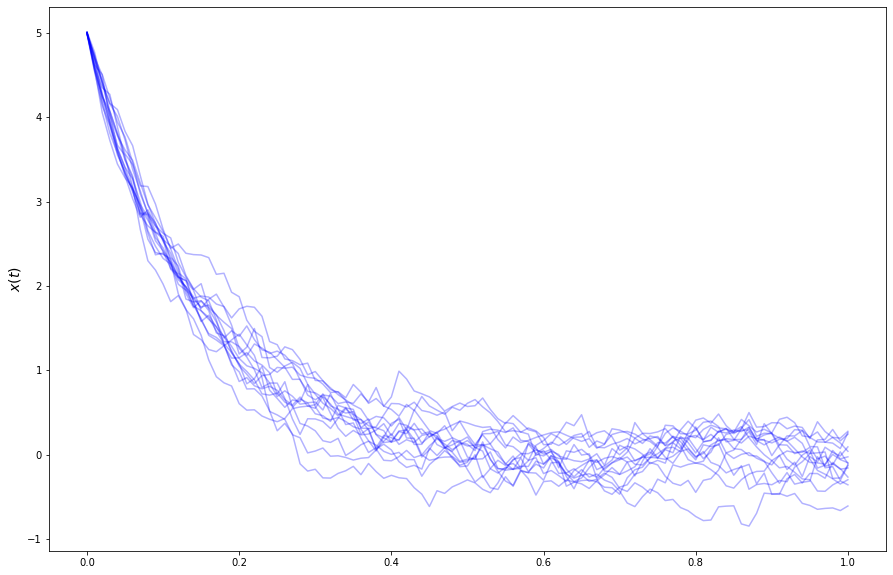

In [249]:
plot_trajectories_2(Xts, t, remove_time=True)

# Fitting Forward Drift with GP
In this section we demonstrate how to fit the forwards drift of an OU process using the GP drift fraemwork. Theres a small problem using Pyro I dont know why it doesnt let me flatten Ys , does it not support multioutput formats for GPs ?

In [ ]:
t_hat,Xts_hat = run(Xts)
fig_axs = plot_trajectories_2(Xts, t, remove_time=True, show=False)
plot_trajectories_2(Xts_hat, t_hat, remove_time=True, fig_axs=fig_axs, color='r');

# Fitting Backwards Drift with GP

In this section we reverse the time series before passing it to the GP. Then we inspect that if starting from the empirical hitting distribution of the OU process namely $X_1$ , where does our GP drift take us to, if correct it should take us back to $X_0$ .

In [231]:
Xbts = copy.deepcopy(Xts)
Xbts[:,:,0] = Xbts[:,:,0].flip(1) # Reverse the series
tb_hat,Xbts_hat  = run(Xbts)

fig_axs = plot_trajectories_2(Xbts, t, remove_time=True, show=False)
plot_trajectories_2(Xbts_hat, tb_hat, remove_time=True, fig_axs=fig_axs, color='r');